# Project B: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

In [ ]:
import os
import numpy as np
# import pandas as pd
import tensorflow
from tensorflow import keras, matmul, reshape
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout, InputLayer
# from keras import regularizers
# import keras.backend as K
from tensorflow.math import exp
from keras.models import Model,load_model
from tensorflow.keras import layers,initializers
# from tensorflow.core.util import event_pb2
# from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import random

# Data loading

In [ ]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir(r'/content/drive/My Drive/KD')

# Model creation

In [ ]:
##@test {"output": "ignore"}

# Build CNN teacher.
cnn_model = tf.keras.Sequential()
cnn_model.add(Conv2D(32,kernel_size=(3,3),strides=1, padding='same',activation='relu', input_shape=(28,28,1)))
cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=1))
cnn_model.add(Conv2D(64,kernel_size= (3,3), strides=1,activation='relu' ))
cnn_model.add(MaxPooling2D(pool_size=(2,2),strides=2))
cnn_model.add(Flatten())
cnn_model.add(Dropout(rate=0.5))
cnn_model.add(Dense(128,activation='relu'))
cnn_model.add(Dropout(rate=0.5))
cnn_model.add(Dense(10))



# Build fully connected student.
fc_model = tf.keras.Sequential()
fc_model.add(Flatten(input_shape=(28,28,1)))
fc_model.add(Dense(784, activation='relu'))
fc_model.add(Dense(784, activation='relu'))
fc_model.add(Dense(10))

fc_model.save_weights('fc_model.h5')



In [ ]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dropout (Dropout)           (None, 9216)              0

In [ ]:
fc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 784)               615440    
                                                                 
 dense_3 (Dense)             (None, 784)               615440    
                                                                 
 dense_4 (Dense)             (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


# Teacher loss function

In [ ]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)
  # Compute cross-entropy loss for subclasses.
  cross_entropy_loss_value =tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, subclass_logits))
  return cross_entropy_loss_value

# Student loss function

In [ ]:
##@test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits/temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits,temperature=DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_subclass_logits))

  return ALPHA*distillation_loss_value+(1.0-ALPHA)*cross_entropy_loss_value 

# Train and evaluation

In [ ]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  accuracy_=[]
  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images,labels)

      grads = tape.gradient(loss_value,model.trainable_variables) 
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model, images, labels)[0]
    Class_accuracy=num_correct / num_total * 100  
    print("Class_accuracy: " + '{:.2f}%'.format(
        Class_accuracy))
    accuracy_.append(Class_accuracy)
  return Class_accuracy


# Training models

In [ ]:
#Teacher model accuracy
print('For the teacher model, the accuracy per epochs:')
Accuracy_Teacher=train_and_evaluate(cnn_model,compute_teacher_loss)


For the teacher model, the accuracy per epochs:
Epoch 1: Class_accuracy: 97.91%
Epoch 2: Class_accuracy: 98.75%
Epoch 3: Class_accuracy: 98.74%
Epoch 4: Class_accuracy: 98.90%
Epoch 5: Class_accuracy: 98.88%
Epoch 6: Class_accuracy: 99.15%
Epoch 7: Class_accuracy: 99.18%
Epoch 8: Class_accuracy: 99.02%
Epoch 9: Class_accuracy: 99.14%
Epoch 10: Class_accuracy: 99.21%
Epoch 11: Class_accuracy: 99.18%
Epoch 12: Class_accuracy: 99.29%


In [ ]:
#cnn_model.save('cnn_model_.h5')

cnn_model=load_model('cnn_model.h5')
# cnn_model.save_weights('cnn_model_weights.h5')

# Alpha and Temperature
ALPHA_spectrum = [0.,0.2,0.5,0.8] 

DISTILLATION_TEMPERATURE_spectrum = [1.,2.,4.,16.,32.,64.] 

In [ ]:
# ALPHA_spectrum = [0.,0.2,0.5,0.8] # task balance between cross-entropy and distillation loss
# DISTILLATION_TEMPERATURE_spectrum = [1.,2.,4.,16.,32.,64.] #temperature hyperparameter
# All_Accuracy_student=[]

# for ALPHA in ALPHA_spectrum:
#   print("\n")
#   print("-------- with alpha of ", ALPHA,"------------")
#   for DISTILLATION_TEMPERATURE in DISTILLATION_TEMPERATURE_spectrum:
#     print("Alpha (", ALPHA, ") and temperature of ", DISTILLATION_TEMPERATURE)
#     print('For the student model, we have the accuracy per epochs of:')
    
#     fc_model = tf.keras.Sequential()
#     fc_model.add(Flatten(input_shape=(28, 28, 1)))
#     fc_model.add(Dense(activation='relu', units=784, input_shape=(28, 28, 1)))
#     fc_model.add(Dense(activation='relu', units=784))
#     fc_model.add(Dense(units=10))

#     Accuracy_student = train_and_evaluate(fc_model, compute_student_loss)
#     fc_model.save('fc_model_alpha'+str(ALPHA)+"_temperature"+str(DISTILLATION_TEMPERATURE)+'.h5')
#     All_Accuracy_student.append(Accuracy_student)

In [ ]:
ALPHA_spectrum = [0.] # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE_spectrum = [16.,32.,64.] #temperature hyperparameter
All_Accuracy_student=[]

for ALPHA in ALPHA_spectrum:
  print("\n")
  print("-------- with alpha of ", ALPHA,"------------")
  for DISTILLATION_TEMPERATURE in DISTILLATION_TEMPERATURE_spectrum:
    print("Alpha (", ALPHA, ") and temperature of ", DISTILLATION_TEMPERATURE)
    print('For the student model, we have the accuracy per epochs of:')
    
    fc_model = tf.keras.Sequential()
    fc_model.add(Flatten(input_shape=(28, 28, 1)))
    fc_model.add(Dense(activation='relu', units=784, input_shape=(28, 28, 1)))
    fc_model.add(Dense(activation='relu', units=784))
    fc_model.add(Dense(units=10))

    Accuracy_student = train_and_evaluate(fc_model, compute_student_loss)
    fc_model.save('fc_model_alpha'+str(ALPHA)+"_temperature"+str(DISTILLATION_TEMPERATURE)+'.h5')
    All_Accuracy_student.append(Accuracy_student)



-------- with alpha of  0.0 ------------
Alpha ( 0.0 ) and temperature of  16.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 96.64%
Epoch 2: Class_accuracy: 97.10%
Epoch 3: Class_accuracy: 97.93%
Epoch 4: Class_accuracy: 98.06%
Epoch 5: Class_accuracy: 97.83%
Epoch 6: Class_accuracy: 97.74%
Epoch 7: Class_accuracy: 98.02%
Epoch 8: Class_accuracy: 98.20%
Epoch 9: Class_accuracy: 97.84%
Epoch 10: Class_accuracy: 98.16%
Epoch 11: Class_accuracy: 97.93%
Epoch 12: Class_accuracy: 98.21%


Alpha ( 0.0 ) and temperature of  32.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 96.91%
Epoch 2: Class_accuracy: 97.56%
Epoch 3: Class_accuracy: 97.63%
Epoch 4: Class_accuracy: 97.65%
Epoch 5: Class_accuracy: 97.94%
Epoch 6: Class_accuracy: 97.80%
Epoch 7: Class_accuracy: 97.82%
Epoch 8: Class_accuracy: 98.01%
Epoch 9: Class_accuracy: 97.69%
Epoch 10: Class_accuracy: 97.98%
Epoch 11: Class_accuracy: 98.10%
Epoch 12: Class_accuracy: 97.77%


Alpha ( 0.0 ) and temperature of  64.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 96.70%
Epoch 2: Class_accuracy: 97.40%
Epoch 3: Class_accuracy: 97.82%
Epoch 4: Class_accuracy: 97.77%
Epoch 5: Class_accuracy: 98.12%
Epoch 6: Class_accuracy: 97.96%
Epoch 7: Class_accuracy: 98.19%
Epoch 8: Class_accuracy: 98.10%
Epoch 9: Class_accuracy: 98.05%
Epoch 10: Class_accuracy: 98.10%
Epoch 11: Class_accuracy: 98.01%
Epoch 12: Class_accuracy: 98.23%


In [ ]:
# #ALPHA_spectrum = [0.,0.2,0.5,0.8] # task balance between cross-entropy and distillation loss
# DISTILLATION_TEMPERATURE_spectrum = [1.,2.,4.,16.,32.,64.] #temperature hyperparameter
# Accuracy_student_0=[]

# #for ALPHA in ALPHA_spectrum:
# ALPHA=0.
# print("\n")
# print("-------- with alpha of ", ALPHA,"------------")
# for DISTILLATION_TEMPERATURE in DISTILLATION_TEMPERATURE_spectrum:
#   print("Alpha (", ALPHA, ") and temperature of ", DISTILLATION_TEMPERATURE)
#   print('For the student model, we have the accuracy per epochs of:')
  
#   fc_model = tf.keras.Sequential()
#   fc_model.add(Flatten(input_shape=(28, 28, 1)))
#   fc_model.add(Dense(activation='relu', units=784, input_shape=(28, 28, 1)))
#   fc_model.add(Dense(activation='relu', units=784))
#   fc_model.add(Dense(units=10))

#   Accuracy_student = train_and_evaluate(fc_model, compute_student_loss)
#   fc_model.save('fc_model_alpha'+str(ALPHA)+"_temperature"+str(DISTILLATION_TEMPERATURE)+'.h5')
#   Accuracy_student_0.append(Accuracy_student)

In [ ]:
# ALPHA_spectrum = [0.,0.2,0.5,0.8] # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE_spectrum = [1.,2.,4.,16.,32.,64.] #temperature hyperparameter
Accuracy_student_02=[]

# for ALPHA in ALPHA_spectrum:
ALPHA=0.2
print("\n")
print("-------- with alpha of ", ALPHA,"------------")
for DISTILLATION_TEMPERATURE in DISTILLATION_TEMPERATURE_spectrum:
  print("Alpha (", ALPHA, ") and temperature of ", DISTILLATION_TEMPERATURE)
  print('For the student model, we have the accuracy per epochs of:')
  
  fc_model = tf.keras.Sequential()
  fc_model.add(Flatten(input_shape=(28, 28, 1)))
  fc_model.add(Dense(activation='relu', units=784, input_shape=(28, 28, 1)))
  fc_model.add(Dense(activation='relu', units=784))
  fc_model.add(Dense(units=10))

  Accuracy_student = train_and_evaluate(fc_model, compute_student_loss)
  fc_model.save('fc_model_alpha'+str(ALPHA)+"_temperature"+str(DISTILLATION_TEMPERATURE)+'.h5')
  Accuracy_student_02.append(Accuracy_student)



-------- with alpha of  0.2 ------------
Alpha ( 0.2 ) and temperature of  1.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 96.10%
Epoch 2: Class_accuracy: 97.05%
Epoch 3: Class_accuracy: 97.74%
Epoch 4: Class_accuracy: 98.16%
Epoch 5: Class_accuracy: 98.22%
Epoch 6: Class_accuracy: 97.94%
Epoch 7: Class_accuracy: 98.09%
Epoch 8: Class_accuracy: 98.32%
Epoch 9: Class_accuracy: 98.08%
Epoch 10: Class_accuracy: 98.01%
Epoch 11: Class_accuracy: 98.30%
Epoch 12: Class_accuracy: 98.23%


Alpha ( 0.2 ) and temperature of  2.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 96.17%
Epoch 2: Class_accuracy: 97.47%
Epoch 3: Class_accuracy: 97.86%
Epoch 4: Class_accuracy: 98.09%
Epoch 5: Class_accuracy: 98.14%
Epoch 6: Class_accuracy: 98.10%
Epoch 7: Class_accuracy: 98.45%
Epoch 8: Class_accuracy: 98.44%
Epoch 9: Class_accuracy: 98.49%
Epoch 10: Class_accuracy: 98.49%
Epoch 11: Class_accuracy: 98.62%
Epoch 12: Class_accuracy: 98.41%


Alpha ( 0.2 ) and temperature of  4.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 96.85%
Epoch 2: Class_accuracy: 97.77%
Epoch 3: Class_accuracy: 98.26%
Epoch 4: Class_accuracy: 98.44%
Epoch 5: Class_accuracy: 98.48%
Epoch 6: Class_accuracy: 98.61%
Epoch 7: Class_accuracy: 98.64%
Epoch 8: Class_accuracy: 98.69%
Epoch 9: Class_accuracy: 98.66%
Epoch 10: Class_accuracy: 98.75%
Epoch 11: Class_accuracy: 98.81%
Epoch 12: Class_accuracy: 98.76%


Alpha ( 0.2 ) and temperature of  16.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 96.94%
Epoch 2: Class_accuracy: 97.85%
Epoch 3: Class_accuracy: 98.33%
Epoch 4: Class_accuracy: 98.49%
Epoch 5: Class_accuracy: 98.49%
Epoch 6: Class_accuracy: 98.56%
Epoch 7: Class_accuracy: 98.67%
Epoch 8: Class_accuracy: 98.72%
Epoch 9: Class_accuracy: 98.78%
Epoch 10: Class_accuracy: 98.74%
Epoch 11: Class_accuracy: 98.84%
Epoch 12: Class_accuracy: 98.74%


Alpha ( 0.2 ) and temperature of  32.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.05%
Epoch 2: Class_accuracy: 97.99%
Epoch 3: Class_accuracy: 98.35%
Epoch 4: Class_accuracy: 98.59%
Epoch 5: Class_accuracy: 98.70%
Epoch 6: Class_accuracy: 98.76%
Epoch 7: Class_accuracy: 98.70%
Epoch 8: Class_accuracy: 98.83%
Epoch 9: Class_accuracy: 98.71%
Epoch 10: Class_accuracy: 98.85%
Epoch 11: Class_accuracy: 98.80%
Epoch 12: Class_accuracy: 98.90%


Alpha ( 0.2 ) and temperature of  64.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.05%
Epoch 2: Class_accuracy: 97.96%
Epoch 3: Class_accuracy: 98.40%
Epoch 4: Class_accuracy: 98.54%
Epoch 5: Class_accuracy: 98.60%
Epoch 6: Class_accuracy: 98.64%
Epoch 7: Class_accuracy: 98.74%
Epoch 8: Class_accuracy: 98.73%
Epoch 9: Class_accuracy: 98.81%
Epoch 10: Class_accuracy: 98.79%
Epoch 11: Class_accuracy: 98.83%
Epoch 12: Class_accuracy: 98.91%


In [ ]:
Accuracy_student_02

[<tf.Tensor: shape=(), dtype=float32, numpy=98.229996>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.409996>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.76>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.74>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.9>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.909996>]

In [ ]:
# ALPHA_spectrum = [0.,0.2,0.5,0.8] # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE_spectrum = [1.,2.,4.,16.,32.,64.] #temperature hyperparameter
Accuracy_student_05=[]

# for ALPHAin ALPHA_spectrum:
ALPHA=0.5
print("\n")
print("-------- with alpha of ", ALPHA,"------------")
for DISTILLATION_TEMPERATURE in DISTILLATION_TEMPERATURE_spectrum:
  print("Alpha (", ALPHA, ") and temperature of ", DISTILLATION_TEMPERATURE)
  print('For the student model, we have the accuracy per epochs of:')
  
  fc_model = tf.keras.Sequential()
  fc_model.add(Flatten(input_shape=(28, 28, 1)))
  fc_model.add(Dense(activation='relu', units=784, input_shape=(28, 28, 1)))
  fc_model.add(Dense(activation='relu', units=784))
  fc_model.add(Dense(units=10))

  Accuracy_student = train_and_evaluate(fc_model, compute_student_loss)
  fc_model.save('fc_model_alpha'+str(ALPHA)+"_temperature"+str(DISTILLATION_TEMPERATURE)+'.h5')
  Accuracy_student_05.append(Accuracy_student)



-------- with alpha of  0.5 ------------
Alpha ( 0.5 ) and temperature of  1.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 96.87%
Epoch 2: Class_accuracy: 97.51%
Epoch 3: Class_accuracy: 97.59%
Epoch 4: Class_accuracy: 98.19%
Epoch 5: Class_accuracy: 97.97%
Epoch 6: Class_accuracy: 97.91%
Epoch 7: Class_accuracy: 98.39%
Epoch 8: Class_accuracy: 98.27%
Epoch 9: Class_accuracy: 98.31%
Epoch 10: Class_accuracy: 98.39%
Epoch 11: Class_accuracy: 98.39%
Epoch 12: Class_accuracy: 98.23%


Alpha ( 0.5 ) and temperature of  2.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 96.57%
Epoch 2: Class_accuracy: 97.62%
Epoch 3: Class_accuracy: 97.97%
Epoch 4: Class_accuracy: 97.99%
Epoch 5: Class_accuracy: 98.18%
Epoch 6: Class_accuracy: 98.25%
Epoch 7: Class_accuracy: 98.40%
Epoch 8: Class_accuracy: 98.49%
Epoch 9: Class_accuracy: 98.46%
Epoch 10: Class_accuracy: 98.60%
Epoch 11: Class_accuracy: 98.53%
Epoch 12: Class_accuracy: 98.51%


Alpha ( 0.5 ) and temperature of  4.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 96.72%
Epoch 2: Class_accuracy: 97.99%
Epoch 3: Class_accuracy: 98.22%
Epoch 4: Class_accuracy: 98.52%
Epoch 5: Class_accuracy: 98.59%
Epoch 6: Class_accuracy: 98.73%
Epoch 7: Class_accuracy: 98.70%
Epoch 8: Class_accuracy: 98.79%
Epoch 9: Class_accuracy: 98.78%
Epoch 10: Class_accuracy: 98.78%
Epoch 11: Class_accuracy: 98.82%
Epoch 12: Class_accuracy: 98.82%


Alpha ( 0.5 ) and temperature of  16.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 96.78%
Epoch 2: Class_accuracy: 97.91%
Epoch 3: Class_accuracy: 98.12%
Epoch 4: Class_accuracy: 98.52%
Epoch 5: Class_accuracy: 98.61%
Epoch 6: Class_accuracy: 98.64%
Epoch 7: Class_accuracy: 98.66%
Epoch 8: Class_accuracy: 98.77%
Epoch 9: Class_accuracy: 98.75%
Epoch 10: Class_accuracy: 98.81%
Epoch 11: Class_accuracy: 98.80%
Epoch 12: Class_accuracy: 98.81%


Alpha ( 0.5 ) and temperature of  32.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 96.73%
Epoch 2: Class_accuracy: 97.92%
Epoch 3: Class_accuracy: 98.36%
Epoch 4: Class_accuracy: 98.52%
Epoch 5: Class_accuracy: 98.55%
Epoch 6: Class_accuracy: 98.74%
Epoch 7: Class_accuracy: 98.68%
Epoch 8: Class_accuracy: 98.74%
Epoch 9: Class_accuracy: 98.80%
Epoch 10: Class_accuracy: 98.75%
Epoch 11: Class_accuracy: 98.81%
Epoch 12: Class_accuracy: 98.81%


Alpha ( 0.5 ) and temperature of  64.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 96.94%
Epoch 2: Class_accuracy: 98.06%
Epoch 3: Class_accuracy: 98.37%
Epoch 4: Class_accuracy: 98.55%
Epoch 5: Class_accuracy: 98.59%
Epoch 6: Class_accuracy: 98.73%
Epoch 7: Class_accuracy: 98.77%
Epoch 8: Class_accuracy: 98.72%
Epoch 9: Class_accuracy: 98.87%
Epoch 10: Class_accuracy: 98.84%
Epoch 11: Class_accuracy: 98.86%
Epoch 12: Class_accuracy: 98.85%


In [ ]:
Accuracy_student_05

[<tf.Tensor: shape=(), dtype=float32, numpy=98.229996>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.509995>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.82>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.81>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.81>,
 <tf.Tensor: shape=(), dtype=float32, numpy=98.85>]

In [ ]:
# ALPHA_spectrum = [0.,0.2,0.5,0.8] # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE_spectrum = [1.,2.,4.,16.,32.,64.] #temperature hyperparameter
Accuracy_student_08=[]

# for ALPHA in ALPHA_spectrum:
ALPHA=0.8 
print("\n")
print("-------- with alpha of ", ALPHA,"------------")
for DISTILLATION_TEMPERATURE in DISTILLATION_TEMPERATURE_spectrum:
  print("Alpha (", ALPHA, ") and temperature of ", DISTILLATION_TEMPERATURE)
  print('For the student model, we have the accuracy per epochs of:')
  
  fc_model = tf.keras.Sequential()
  fc_model.add(Flatten(input_shape=(28, 28, 1)))
  fc_model.add(Dense(activation='relu', units=784, input_shape=(28, 28, 1)))
  fc_model.add(Dense(activation='relu', units=784))
  fc_model.add(Dense(units=10))

  Accuracy_student = train_and_evaluate(fc_model, compute_student_loss)
  fc_model.save('fc_model_alpha'+str(ALPHA)+"_temperature"+str(DISTILLATION_TEMPERATURE)+'.h5')
  Accuracy_student_08.append(Accuracy_student)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir(r'/content/drive/My Drive/KD')

Mounted at /content/drive


In [ ]:
ALPHA_spectrum = [0.,0.2,0.5,0.8] # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE_spectrum = [1.,2.,4.,16.,32.,64.] 
All_Accuracy_student=[]
for ALPHA in ALPHA_spectrum:
  print("\n")
  print("-------- with alpha of ", ALPHA,"------------")
  for DISTILLATION_TEMPERATURE in DISTILLATION_TEMPERATURE_spectrum:
    model=load_model('fc_model_alpha'+str(ALPHA)+"_temperature"+str(DISTILLATION_TEMPERATURE)+'.h5')
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model, images, labels)[0]
    Class_accuracy=num_correct / num_total * 100  
    print('\n')
    print("Class_accuracy of "+'fc_model with alpha of '+str(ALPHA)+" and temperature of "+str(DISTILLATION_TEMPERATURE) + 'is {:.2f}%'.format(
        Class_accuracy))
    print('\n')
    All_Accuracy_student.append(Class_accuracy)



-------- with alpha of  0.0 ------------




Class_accuracy of fc_model with alpha of 0.0 and temperature of 1.0is 98.84%






Class_accuracy of fc_model with alpha of 0.0 and temperature of 2.0is 98.86%






Class_accuracy of fc_model with alpha of 0.0 and temperature of 4.0is 98.69%






Class_accuracy of fc_model with alpha of 0.0 and temperature of 16.0is 98.87%






Class_accuracy of fc_model with alpha of 0.0 and temperature of 32.0is 98.70%






Class_accuracy of fc_model with alpha of 0.0 and temperature of 64.0is 98.72%




-------- with alpha of  0.2 ------------




Class_accuracy of fc_model with alpha of 0.2 and temperature of 1.0is 98.84%






Class_accuracy of fc_model with alpha of 0.2 and temperature of 2.0is 98.94%






Class_accuracy of fc_model with alpha of 0.2 and temperature of 4.0is 99.22%






Class_accuracy of fc_model with alpha of 0.2 and temperature of 16.0is 99.15%






Class_accuracy of fc_model with alpha of 0.2 and temperature of 32.0is 99.26%






Class_accuracy of fc_model with alpha of 0.2 and temperature of 64.0is 99.25%




-------- with alpha of  0.5 ------------




Class_accuracy of fc_model with alpha of 0.5 and temperature of 1.0is 98.88%






Class_accuracy of fc_model with alpha of 0.5 and temperature of 2.0is 99.01%






Class_accuracy of fc_model with alpha of 0.5 and temperature of 4.0is 99.22%






Class_accuracy of fc_model with alpha of 0.5 and temperature of 16.0is 99.15%






Class_accuracy of fc_model with alpha of 0.5 and temperature of 32.0is 99.20%






Class_accuracy of fc_model with alpha of 0.5 and temperature of 64.0is 99.24%




-------- with alpha of  0.8 ------------




Class_accuracy of fc_model with alpha of 0.8 and temperature of 1.0is 98.87%






Class_accuracy of fc_model with alpha of 0.8 and temperature of 2.0is 99.07%






Class_accuracy of fc_model with alpha of 0.8 and temperature of 4.0is 99.18%






Class_accuracy of fc_model with alpha of 0.8 and temperature of 16.0is 99.14%






Class_accuracy of fc_model with alpha of 0.8 and temperature of 32.0is 99.25%






Class_accuracy of fc_model with alpha of 0.8 and temperature of 64.0is 99.17%




In [ ]:
ALPHA_spectrum = [0.,0.2,0.5,0.8] # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE_spectrum = [1.,2.,4.,16.,32.,64.] 
All_Accuracy_student=[]
for ALPHA in ALPHA_spectrum:
  print("\n")
  print("-------- with alpha of ", ALPHA,"------------")
  for DISTILLATION_TEMPERATURE in DISTILLATION_TEMPERATURE_spectrum:
    model=load_model('fc_model_alpha'+str(ALPHA)+"_temperature"+str(DISTILLATION_TEMPERATURE)+'.h5')
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model, images, labels)[0]
    Class_accuracy=num_correct / num_total * 100  
    print('\n')
    print("Class_accuracy of "+'fc_model with alpha of '+str(ALPHA)+" and temperature of "+str(DISTILLATION_TEMPERATURE) + 'is {:.2f}%'.format(
        Class_accuracy))
    print('\n')
    All_Accuracy_student.append(Class_accuracy)



-------- with alpha of  0.0 ------------




Class_accuracy of fc_model with alpha of 0.0 and temperature of 1.0is 98.06%






Class_accuracy of fc_model with alpha of 0.0 and temperature of 2.0is 98.20%






Class_accuracy of fc_model with alpha of 0.0 and temperature of 4.0is 97.83%






Class_accuracy of fc_model with alpha of 0.0 and temperature of 16.0is 98.21%






Class_accuracy of fc_model with alpha of 0.0 and temperature of 32.0is 97.77%






Class_accuracy of fc_model with alpha of 0.0 and temperature of 64.0is 98.23%




-------- with alpha of  0.2 ------------




Class_accuracy of fc_model with alpha of 0.2 and temperature of 1.0is 98.23%






Class_accuracy of fc_model with alpha of 0.2 and temperature of 2.0is 98.41%






Class_accuracy of fc_model with alpha of 0.2 and temperature of 4.0is 98.76%






Class_accuracy of fc_model with alpha of 0.2 and temperature of 16.0is 98.74%






Class_accuracy of fc_model with alpha of 0.2 and temperature of 32.0is 98.90%






Class_accuracy of fc_model with alpha of 0.2 and temperature of 64.0is 98.91%




-------- with alpha of  0.5 ------------




Class_accuracy of fc_model with alpha of 0.5 and temperature of 1.0is 98.23%






Class_accuracy of fc_model with alpha of 0.5 and temperature of 2.0is 98.51%






Class_accuracy of fc_model with alpha of 0.5 and temperature of 4.0is 98.82%






Class_accuracy of fc_model with alpha of 0.5 and temperature of 16.0is 98.81%






Class_accuracy of fc_model with alpha of 0.5 and temperature of 32.0is 98.81%






Class_accuracy of fc_model with alpha of 0.5 and temperature of 64.0is 98.85%




-------- with alpha of  0.8 ------------




Class_accuracy of fc_model with alpha of 0.8 and temperature of 1.0is 98.12%






Class_accuracy of fc_model with alpha of 0.8 and temperature of 2.0is 98.55%






Class_accuracy of fc_model with alpha of 0.8 and temperature of 4.0is 98.75%






Class_accuracy of fc_model with alpha of 0.8 and temperature of 16.0is 98.79%






Class_accuracy of fc_model with alpha of 0.8 and temperature of 32.0is 98.83%






Class_accuracy of fc_model with alpha of 0.8 and temperature of 64.0is 98.82%




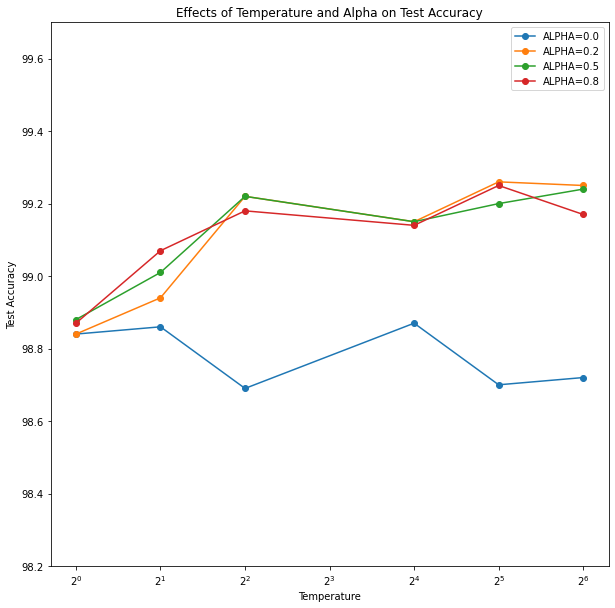

<Figure size 432x288 with 0 Axes>

In [ ]:
Accuracy_student_0_, Accuracy_student_02_, Accuracy_student_05_, Accuracy_student_08_ = All_Accuracy_student[0: 6],All_Accuracy_student[6: 12],All_Accuracy_student[12: 18],All_Accuracy_student[18: 24] 

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xscale('log',basex=2)
ax.plot(DISTILLATION_TEMPERATURE_spectrum,Accuracy_student_0_, marker='o', label='ALPHA=0.0')
ax.plot(DISTILLATION_TEMPERATURE_spectrum, Accuracy_student_02_, marker='o', label='ALPHA=0.2')
ax.plot(DISTILLATION_TEMPERATURE_spectrum, Accuracy_student_05_, marker='o', label='ALPHA=0.5')
ax.plot(DISTILLATION_TEMPERATURE_spectrum, Accuracy_student_08_, marker='o', label='ALPHA=0.8')
plt.ylim(98.2,99.7)
plt.ylabel('Test Accuracy')
plt.xlabel('Temperature')
plt.title('Effects of Temperature and Alpha on Test Accuracy')
plt.legend()
plt.show()
plt.savefig('talphatestaccuracy.png')

# Test accuracy vs. tempreture curve

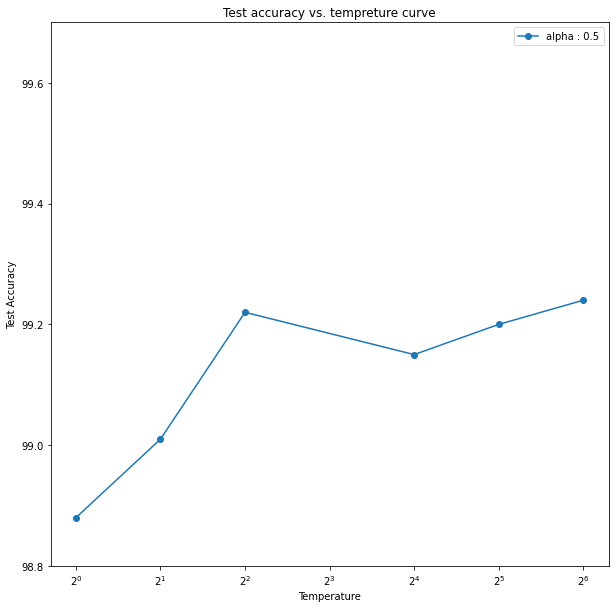

<Figure size 432x288 with 0 Axes>

In [ ]:
# your code start from here for step 6
ALPHA=0.5
DISTILLATION_TEMPERATURE_spectrum = [1.,2.,4.,16.,32.,64.]
Accuracy_st=Accuracy_student_05_
fig, ax=plt.subplots(figsize=(10,10))
ax.set_xscale('log',basex=2)
ax.plot(DISTILLATION_TEMPERATURE_spectrum, Accuracy_st,marker='o', label='alpha : 0.5')
plt.ylim(98.8,99.7)
plt.xlabel('Temperature')
plt.ylabel('Test Accuracy')
plt.title("Test accuracy vs. tempreture curve")
plt.legend()
plt.show()
plt.savefig('Testaccuracytempreturecurve_alpha05.png')

# Train student from scratch

In [ ]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential()

# your code start from here for step 7
fc_model_no_distillation.add(Flatten(input_shape=(28,28,1)))
fc_model_no_distillation.add(Dense(784, activation='relu'))
fc_model_no_distillation.add(Dense(784, activation='relu'))
fc_model_no_distillation.add(Dense(10))


##@test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels,student_subclass_logits))
  
  return cross_entropy_loss


train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)
fc_model_no_distillation.save('fc_model_no_distillation.h5')

Epoch 1: Class_accuracy: 96.72%
Epoch 2: Class_accuracy: 97.58%
Epoch 3: Class_accuracy: 97.89%
Epoch 4: Class_accuracy: 98.03%
Epoch 5: Class_accuracy: 98.20%
Epoch 6: Class_accuracy: 97.80%
Epoch 7: Class_accuracy: 98.11%
Epoch 8: Class_accuracy: 98.13%
Epoch 9: Class_accuracy: 98.11%
Epoch 10: Class_accuracy: 98.14%
Epoch 11: Class_accuracy: 98.27%
Epoch 12: Class_accuracy: 98.16%


# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [ ]:
!pip install keras-flops

     |████████████████████████████████| 462 kB 5.4 MB/s 


In [ ]:
from keras_flops import get_flops

In [ ]:
# your code start from here for step 8
cnn_model.summary()
cnn_flops=get_flops(cnn_model, batch_size=BATCH_SIZE)
print('\n')
print(f'Teacher model FLOPs: {cnn_flops/10**9}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dropout (Dropout)           (None, 9216)              0

In [ ]:
fc_model.summary()
fc_flops=get_flops(fc_model, batch_size=BATCH_SIZE)
print('\n')
print(f'Student model FLOPs: {fc_flops/10**9}')

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_16 (Flatten)        (None, 784)               0         
                                                                 
 dense_47 (Dense)            (None, 784)               615440    
                                                                 
 dense_48 (Dense)            (None, 784)               615440    
                                                                 
 dense_49 (Dense)            (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


Student model FLOPs: 0.633825792


In [ ]:
fc_model_no_distillation.summary()
fc_model_no_distillation_flops=get_flops(fc_model_no_distillation, batch_size=BATCH_SIZE)
print('\n')
print(f'Student model without KD FLOPs: {fc_model_no_distillation_flops/10**9}')

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_17 (Flatten)        (None, 784)               0         
                                                                 
 dense_50 (Dense)            (None, 784)               615440    
                                                                 
 dense_51 (Dense)            (None, 784)               615440    
                                                                 
 dense_52 (Dense)            (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


Student model without KD FLOPs: 0.633825792


# XAI method to explain models

In [ ]:
# your code start from here for step 9
#@title Integrated gradient
def gradients_(input, model, pred_index):
  images = tf.convert_to_tensor(input,dtype='float32')

  with tf.GradientTape() as tape:
    tape.watch(images)
    preds=model(images)
    grads = tape.gradient(preds[:, pred_index],images)
  return grads

def IG(input, model, label, knots=50):
  steps = np.linspace(0.,1.,knots+1)[1:]
  interpolated_image = np.empty((knots,28,28,1))

  for i in range(knots):
    interpolated_image[i] = input * steps[i]
  
  grads = gradients_(interpolated_image, model, tf.math.argmax(label,axis=1)[0])
  ave_grad = tf.math.reduce_mean(grads,axis=0) 
  ave_grad = input * ave_grad
  
  return ave_grad



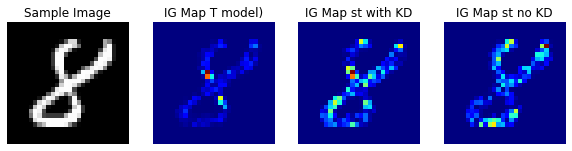

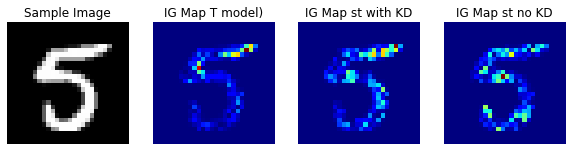

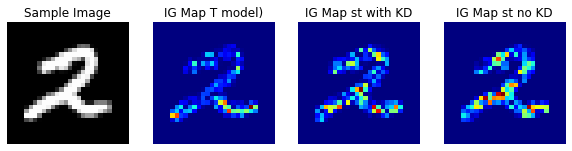

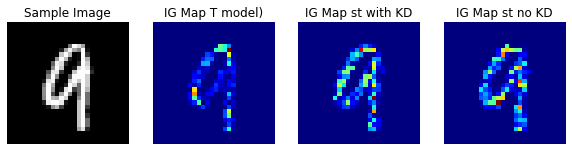

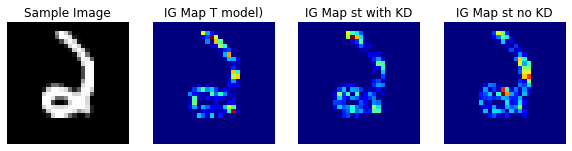

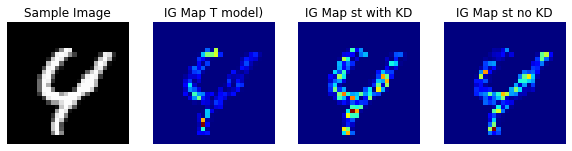

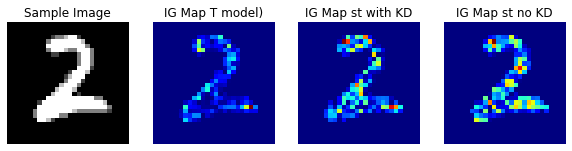

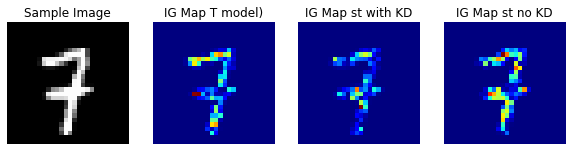

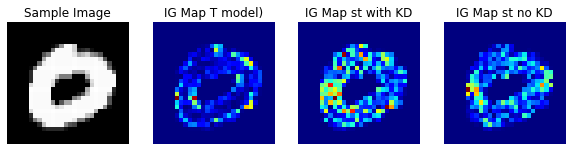

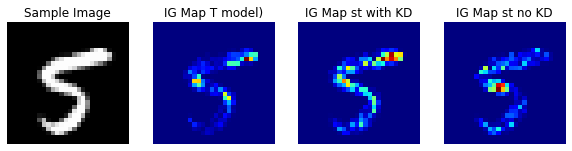

<Figure size 432x288 with 0 Axes>

In [ ]:
#visualization

def Explanation_Map_IG(ex_mp):
  em = np.average(abs(ex_mp),axis=2)
  em -= em.min()
  em /= em.max()+10e-30
  return em

x=random.randint(1,40)
for i in range(x,x+10):
  for images, labels in mnist_test:
    sample = images[i:i+1]
    sample_labels = labels[i:i+1]
    break
  IG_t = IG(sample,cnn_model,sample_labels)
  IG_withKD_student = IG(sample,fc_model,sample_labels)
  IG_student_no_distillation = IG(sample,fc_model_no_distillation,sample_labels)

  plt.figure(figsize=(10,5))
  plt.subplot(1,4,1)
  plt.imshow(sample.numpy().reshape((28,28)),cmap='gray')
  plt.axis('off')
  plt.title('Sample Image')

  plt.subplot(1,4,2)
  plt.imshow(Explanation_Map_IG(IG_t[0]).reshape((28,28)),cmap='jet')
  plt.axis('off')
  plt.title('IG Map T model)')

  plt.subplot(1,4,3)
  plt.imshow(Explanation_Map_IG(IG_withKD_student[0]).reshape((28,28)),cmap='jet')
  plt.axis('off')
  plt.title('IG Map st with KD')

  plt.subplot(1,4,4)
  plt.imshow(Explanation_Map_IG(IG_student_no_distillation[0]).reshape((28,28)),cmap='jet')
  plt.axis('off')
  plt.title('IG Map st no KD')
  plt.show()

plt.savefig('XAI method.png')

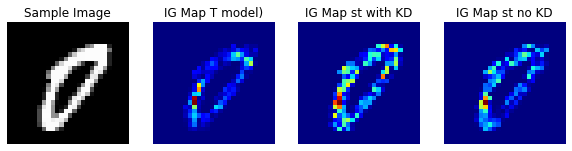

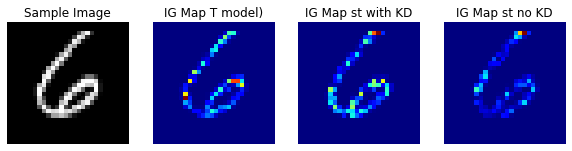

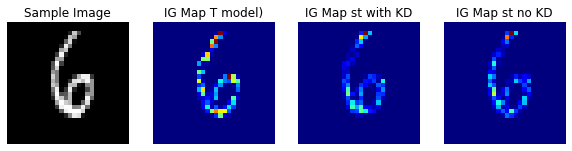

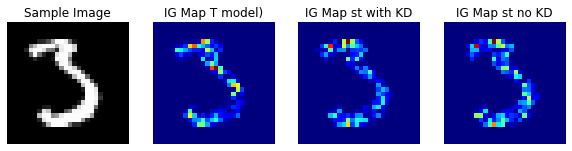

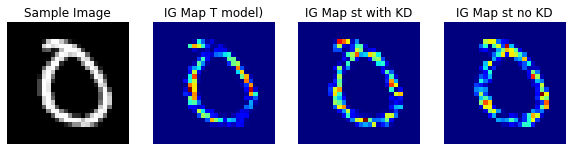

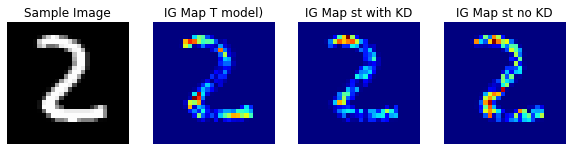

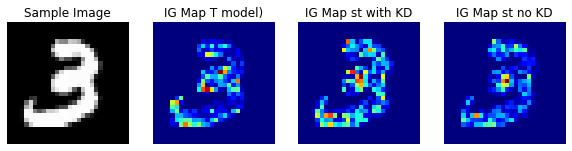

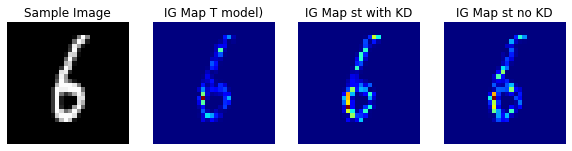

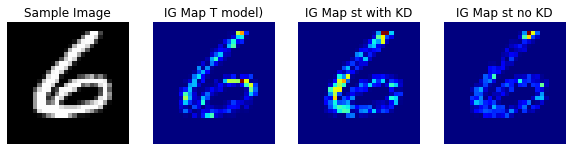

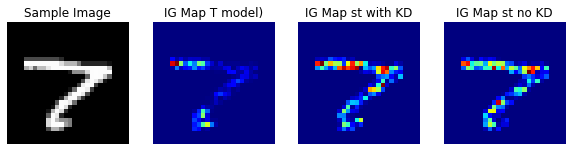

In [ ]:
#visualization

def Explanation_Map_IG(ex_mp):
  em = np.average(abs(ex_mp),axis=2)
  em -= em.min()
  em /= em.max()+10e-30
  return em

x=random.randint(1,40)
for i in range(x,x+10):
  for images, labels in mnist_test:
    sample = images[i:i+1]
    sample_labels = labels[i:i+1]
    break
  IG_t = IG(sample,cnn_model,sample_labels)
  IG_withKD_student = IG(sample,fc_model,sample_labels)
  IG_student_no_distillation = IG(sample,fc_model_no_distillation,sample_labels)

  plt.figure(figsize=(10,5))
  plt.subplot(1,4,1)
  plt.imshow(sample.numpy().reshape((28,28)),cmap='gray')
  plt.axis('off')
  plt.title('Sample Image')

  plt.subplot(1,4,2)
  plt.imshow(Explanation_Map_IG(IG_t[0]).reshape((28,28)),cmap='jet')
  plt.axis('off')
  plt.title('IG Map T model)')

  plt.subplot(1,4,3)
  plt.imshow(Explanation_Map_IG(IG_withKD_student[0]).reshape((28,28)),cmap='jet')
  plt.axis('off')
  plt.title('IG Map st with KD')

  plt.subplot(1,4,4)
  plt.imshow(Explanation_Map_IG(IG_student_no_distillation[0]).reshape((28,28)),cmap='jet')
  plt.axis('off')
  plt.title('IG Map st no KD')
  plt.show()

plt.savefig('XAI method.png')

# Implementing the state-of-the-art KD algorithm

In [ ]:
# #subclass distillation
# #Rafael M ̈uller, Simon Kornblith, and Geoffrey Hinton. Subclass distillation. arXiv preprint
# arXiv:2002.03936, 2020. https://arxiv.org/abs/2002.03936.

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 2
NUM_SUBCLASSES = 10

ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4.
BETA = 1.0
AUXILIARY_TEMPERATURE = 1.0

In [ ]:
import os
import numpy as np
# import pandas as pd
import tensorflow
from tensorflow import keras, matmul, reshape
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import optimizers
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout, InputLayer
# from keras import regularizers
# import keras.backend as K
from tensorflow.math import exp
from keras.models import Model,load_model
from tensorflow.keras import layers,initializers
# from tensorflow.core.util import event_pb2
# from tensorflow.python.lib.io import tf_record
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import random


In [ ]:
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  labels = tf.reduce_sum(tf.reshape(subclass_labels, (NUM_CLASSES, NUM_SUBCLASSES // NUM_CLASSES)), -1)
  return image, labels

mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

In [ ]:
# your code start from here for step 13
##@test {"output": "ignore"}

# Build CNN teacher.
cnn_model = tf.keras.Sequential()
cnn_model.add(Conv2D(32,kernel_size=(3,3),strides=1, padding='same',activation='relu', input_shape=(28,28,1)))
cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=1))
cnn_model.add(Conv2D(64,kernel_size= (3,3), strides=1,activation='relu' ))
cnn_model.add(MaxPooling2D(pool_size=(2,2),strides=2))
cnn_model.add(Flatten())
cnn_model.add(Dropout(rate=0.5))
cnn_model.add(Dense(128,activation='relu'))
cnn_model.add(Dropout(rate=0.5))
cnn_model.add(Dense(10))



# Build fully connected student.
fc_model = tf.keras.Sequential()
fc_model.add(Flatten(input_shape=(28,28,1)))
fc_model.add(Dense(784, activation='relu'))
fc_model.add(Dense(784, activation='relu'))
fc_model.add(Dense(10))

fc_model.save_weights('fc_model_.h5')

In [ ]:
# Teacher Loss Function
def auxiliary_loss(subclass_logits: tf.Tensor, temperature: Union[float, tf.Tensor]):
  temperature = tf.convert_to_tensor(temperature, dtype=subclass_logits.dtype)
  mean, var = tf.nn.moments(subclass_logits, -1, keepdims=True)
  num_subclasses = tf.convert_to_tensor(NUM_SUBCLASSES / NUM_CLASSES, dtype=subclass_logits.dtype)

  epsilon = tf.convert_to_tensor(1e-9, dtype=subclass_logits.dtype)

  vi = tf.nn.batch_normalization(subclass_logits, mean=mean, variance=var, offset=None, scale=1./ tf.sqrt(temperature * num_subclasses), variance_epsilon=epsilon)
  n = tf.cast(BATCH_SIZE, subclass_logits.dtype)

  products = tf.linalg.matmul(vi, vi, transpose_b=True)
  return (tf.math.reduce_mean(tf.math.reduce_logsumexp(products, -1)) - 1/temperature -tf.math.log(n))

def compute_teacher_loss(images, labels):

  subclass_logits = cnn_model(images, training=True)

  # cross entropy 
  subclass_logits = tf.reshape(subclass_logits, (-1, NUM_CLASSES, NUM_SUBCLASSES // NUM_CLASSES))
  class_logits = tf.math.reduce_logsumexp(subclass_logits, -1)
  cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels, class_logits)

  auxiliary_loss_value = auxiliary_loss(subclass_logits, AUXILIARY_TEMPERATURE)

  return cross_entropy_loss_value + BETA * auxiliary_loss_value

In [ ]:
# Student Loss function
def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor, temperature: Union[float, tf.Tensor]):

  soft_targets = tf.nn.softmax(teacher_logits / temperature)
  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2


def compute_student_loss_sub(images, labels):

  student_subclass_logits = fc_model(images, training=True)

  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

  subclass_logits = tf.reshape(student_subclass_logits, (-1, NUM_CLASSES, NUM_SUBCLASSES // NUM_CLASSES))
  class_logits = tf.math.reduce_logsumexp(subclass_logits, -1)

  cross_entropy_loss_value = ALPHA * tf.nn.softmax_cross_entropy_with_logits(labels, class_logits) + (1.0 - ALPHA) * distillation_loss_value
  return cross_entropy_loss_value

In [ ]:
# Train and evaluation
def compute_num_correct(model, images, labels):

  subclass_logits = model(images, training=False)
  subclass_logits = tf.reshape(subclass_logits, (-1, NUM_CLASSES, NUM_SUBCLASSES // NUM_CLASSES))
  class_logits = tf.math.reduce_logsumexp(subclass_logits, -1)

  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)

def train_and_evaluate(model, compute_loss_fn):

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
        loss_value = compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      num_correct += compute_num_correct(model, images, labels)[0].numpy()
    Class_accuracy= num_correct / num_total * 100
    print("Class_accuracy: " + '{:.2f}%'.format(Class_accuracy))
  return Class_accuracy 

In [ ]:
#Teacher model accuracy
print('For the teacher model, the accuracy per epochs:')
sub_Accuracy_Teacher=train_and_evaluate(cnn_model,compute_teacher_loss)

For the teacher model, the accuracy per epochs:
Epoch 1: Class_accuracy: 97.64%
Epoch 2: Class_accuracy: 98.55%
Epoch 3: Class_accuracy: 98.84%
Epoch 4: Class_accuracy: 98.99%
Epoch 5: Class_accuracy: 98.96%
Epoch 6: Class_accuracy: 99.17%
Epoch 7: Class_accuracy: 99.17%
Epoch 8: Class_accuracy: 99.23%
Epoch 9: Class_accuracy: 99.32%
Epoch 10: Class_accuracy: 99.21%
Epoch 11: Class_accuracy: 99.24%
Epoch 12: Class_accuracy: 99.26%


In [ ]:
#cnn_model.save('cnn_model_subclassds.h5')
cnn_model=load_model('cnn_model_subclassds.h5')
#cnn_model.save_weights('cnn_model_subclassds_weights.h5')

In [ ]:
ALPHA_spectrum = [0.,0.2,0.5,0.8] # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE_spectrum = [1.,2.,4.,16.,32.,64.] #temperature hyperparameter

In [ ]:
DISTILLATION_TEMPERATURE_spectrum = [1.,2.,4.,16.,32.,64.] #temperature hyperparameter
sub_Accuracy_student_00=[]

# for ALPHA in ALPHA_spectrum:
ALPHA=0.0
print("\n")
print("-------- with alpha of ", ALPHA,"------------")
for DISTILLATION_TEMPERATURE in DISTILLATION_TEMPERATURE_spectrum:
  print("Alpha (", ALPHA, ") and temperature of ", DISTILLATION_TEMPERATURE)
  print('For the student model, we have the accuracy per epochs of:')
  
  fc_model = tf.keras.Sequential()
  fc_model.add(Flatten(input_shape=(28, 28, 1)))
  fc_model.add(Dense(activation='relu', units=784, input_shape=(28, 28, 1)))
  fc_model.add(Dense(activation='relu', units=784))
  fc_model.add(Dense(units=10))

  Accuracy_student_sb = train_and_evaluate(fc_model, compute_student_loss_sub)
  fc_model.save('sub_fc_model_alpha'+str(ALPHA)+"_temperature"+str(DISTILLATION_TEMPERATURE)+'.h5')
  sub_Accuracy_student_00.append(Accuracy_student_sb)



-------- with alpha of  0.0 ------------
Alpha ( 0.0 ) and temperature of  1.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.49%
Epoch 2: Class_accuracy: 98.06%
Epoch 3: Class_accuracy: 98.23%
Epoch 4: Class_accuracy: 98.29%
Epoch 5: Class_accuracy: 98.33%
Epoch 6: Class_accuracy: 98.47%
Epoch 7: Class_accuracy: 98.13%
Epoch 8: Class_accuracy: 98.39%
Epoch 9: Class_accuracy: 98.46%
Epoch 10: Class_accuracy: 98.53%
Epoch 11: Class_accuracy: 98.54%
Epoch 12: Class_accuracy: 98.64%


Alpha ( 0.0 ) and temperature of  2.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.38%
Epoch 2: Class_accuracy: 98.05%
Epoch 3: Class_accuracy: 98.22%
Epoch 4: Class_accuracy: 98.24%
Epoch 5: Class_accuracy: 98.41%
Epoch 6: Class_accuracy: 98.51%
Epoch 7: Class_accuracy: 98.57%
Epoch 8: Class_accuracy: 98.58%
Epoch 9: Class_accuracy: 98.66%
Epoch 10: Class_accuracy: 98.65%
Epoch 11: Class_accuracy: 98.61%
Epoch 12: Class_accuracy: 98.70%


Alpha ( 0.0 ) and temperature of  4.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.54%
Epoch 2: Class_accuracy: 98.22%
Epoch 3: Class_accuracy: 98.27%
Epoch 4: Class_accuracy: 98.45%
Epoch 5: Class_accuracy: 98.51%
Epoch 6: Class_accuracy: 98.54%
Epoch 7: Class_accuracy: 98.58%
Epoch 8: Class_accuracy: 98.53%
Epoch 9: Class_accuracy: 98.54%
Epoch 10: Class_accuracy: 98.60%
Epoch 11: Class_accuracy: 98.70%
Epoch 12: Class_accuracy: 98.67%


Alpha ( 0.0 ) and temperature of  16.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.07%
Epoch 2: Class_accuracy: 97.86%
Epoch 3: Class_accuracy: 98.07%
Epoch 4: Class_accuracy: 98.23%
Epoch 5: Class_accuracy: 98.31%
Epoch 6: Class_accuracy: 98.32%
Epoch 7: Class_accuracy: 98.54%
Epoch 8: Class_accuracy: 98.48%
Epoch 9: Class_accuracy: 98.58%
Epoch 10: Class_accuracy: 98.63%
Epoch 11: Class_accuracy: 98.49%
Epoch 12: Class_accuracy: 98.55%


Alpha ( 0.0 ) and temperature of  32.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.30%
Epoch 2: Class_accuracy: 97.91%
Epoch 3: Class_accuracy: 98.23%
Epoch 4: Class_accuracy: 98.22%
Epoch 5: Class_accuracy: 98.40%
Epoch 6: Class_accuracy: 98.34%
Epoch 7: Class_accuracy: 98.43%
Epoch 8: Class_accuracy: 98.51%
Epoch 9: Class_accuracy: 98.48%
Epoch 10: Class_accuracy: 98.39%
Epoch 11: Class_accuracy: 98.40%
Epoch 12: Class_accuracy: 98.59%


Alpha ( 0.0 ) and temperature of  64.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.35%
Epoch 2: Class_accuracy: 97.73%
Epoch 3: Class_accuracy: 98.19%
Epoch 4: Class_accuracy: 98.43%
Epoch 5: Class_accuracy: 98.46%
Epoch 6: Class_accuracy: 98.51%
Epoch 7: Class_accuracy: 98.53%
Epoch 8: Class_accuracy: 98.55%
Epoch 9: Class_accuracy: 98.58%
Epoch 10: Class_accuracy: 98.48%
Epoch 11: Class_accuracy: 98.53%
Epoch 12: Class_accuracy: 98.74%


In [ ]:
sub_Accuracy_student_00

[98.64, 98.7, 98.67, 98.55000000000001, 98.59, 98.74000000000001]

In [ ]:
DISTILLATION_TEMPERATURE_spectrum = [1.,2.,4.,16.,32.,64.] #temperature hyperparameter
sub_Accuracy_student_02=[]

# for ALPHA in ALPHA_spectrum:
ALPHA=0.2
print("\n")
print("-------- with alpha of ", ALPHA,"------------")
for DISTILLATION_TEMPERATURE in DISTILLATION_TEMPERATURE_spectrum:
  print("Alpha (", ALPHA, ") and temperature of ", DISTILLATION_TEMPERATURE)
  print('For the student model, we have the accuracy per epochs of:')
  
  fc_model = tf.keras.Sequential()
  fc_model.add(Flatten(input_shape=(28, 28, 1)))
  fc_model.add(Dense(activation='relu', units=784, input_shape=(28, 28, 1)))
  fc_model.add(Dense(activation='relu', units=784))
  fc_model.add(Dense(units=10))

  Accuracy_student_sb = train_and_evaluate(fc_model, compute_student_loss_sub)
  fc_model.save('sub_fc_model_alpha'+str(ALPHA)+"_temperature"+str(DISTILLATION_TEMPERATURE)+'.h5')
  sub_Accuracy_student_02.append(Accuracy_student_sb)



-------- with alpha of  0.2 ------------
Alpha ( 0.2 ) and temperature of  1.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.46%
Epoch 2: Class_accuracy: 98.01%
Epoch 3: Class_accuracy: 98.22%
Epoch 4: Class_accuracy: 98.38%
Epoch 5: Class_accuracy: 98.38%
Epoch 6: Class_accuracy: 98.45%
Epoch 7: Class_accuracy: 98.48%
Epoch 8: Class_accuracy: 98.45%
Epoch 9: Class_accuracy: 98.56%
Epoch 10: Class_accuracy: 98.59%
Epoch 11: Class_accuracy: 98.55%
Epoch 12: Class_accuracy: 98.57%


Alpha ( 0.2 ) and temperature of  2.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.52%
Epoch 2: Class_accuracy: 97.90%
Epoch 3: Class_accuracy: 98.38%
Epoch 4: Class_accuracy: 98.44%
Epoch 5: Class_accuracy: 98.50%
Epoch 6: Class_accuracy: 98.52%
Epoch 7: Class_accuracy: 98.57%
Epoch 8: Class_accuracy: 98.50%
Epoch 9: Class_accuracy: 98.50%
Epoch 10: Class_accuracy: 98.62%
Epoch 11: Class_accuracy: 98.62%
Epoch 12: Class_accuracy: 98.62%


Alpha ( 0.2 ) and temperature of  4.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.47%
Epoch 2: Class_accuracy: 98.12%
Epoch 3: Class_accuracy: 98.51%
Epoch 4: Class_accuracy: 98.43%
Epoch 5: Class_accuracy: 98.49%
Epoch 6: Class_accuracy: 98.54%
Epoch 7: Class_accuracy: 98.46%
Epoch 8: Class_accuracy: 98.66%
Epoch 9: Class_accuracy: 98.55%
Epoch 10: Class_accuracy: 98.62%
Epoch 11: Class_accuracy: 98.57%
Epoch 12: Class_accuracy: 98.71%


Alpha ( 0.2 ) and temperature of  16.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.13%
Epoch 2: Class_accuracy: 97.97%
Epoch 3: Class_accuracy: 98.17%
Epoch 4: Class_accuracy: 98.19%
Epoch 5: Class_accuracy: 98.49%
Epoch 6: Class_accuracy: 98.48%
Epoch 7: Class_accuracy: 98.42%
Epoch 8: Class_accuracy: 98.54%
Epoch 9: Class_accuracy: 98.52%
Epoch 10: Class_accuracy: 98.53%
Epoch 11: Class_accuracy: 98.51%
Epoch 12: Class_accuracy: 98.60%


Alpha ( 0.2 ) and temperature of  32.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.40%
Epoch 2: Class_accuracy: 97.83%
Epoch 3: Class_accuracy: 98.17%
Epoch 4: Class_accuracy: 98.30%
Epoch 5: Class_accuracy: 98.37%
Epoch 6: Class_accuracy: 98.45%
Epoch 7: Class_accuracy: 98.48%
Epoch 8: Class_accuracy: 98.45%
Epoch 9: Class_accuracy: 98.50%
Epoch 10: Class_accuracy: 98.50%
Epoch 11: Class_accuracy: 98.54%
Epoch 12: Class_accuracy: 98.50%


Alpha ( 0.2 ) and temperature of  64.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.18%
Epoch 2: Class_accuracy: 98.01%
Epoch 3: Class_accuracy: 98.09%
Epoch 4: Class_accuracy: 98.20%
Epoch 5: Class_accuracy: 98.33%
Epoch 6: Class_accuracy: 98.24%
Epoch 7: Class_accuracy: 98.43%
Epoch 8: Class_accuracy: 98.49%
Epoch 9: Class_accuracy: 98.39%
Epoch 10: Class_accuracy: 98.45%
Epoch 11: Class_accuracy: 98.55%
Epoch 12: Class_accuracy: 98.55%


In [ ]:
sub_Accuracy_student_02

[98.57000000000001, 98.61999999999999, 98.71, 98.6, 98.5, 98.55000000000001]

In [ ]:
DISTILLATION_TEMPERATURE_spectrum = [1.,2.,4.,16.,32.,64.] #temperature hyperparameter
sub_Accuracy_student_05=[]

# for ALPHA in ALPHA_spectrum:
ALPHA=0.5
print("\n")
print("-------- with alpha of ", ALPHA,"------------")
for DISTILLATION_TEMPERATURE in DISTILLATION_TEMPERATURE_spectrum:
  print("Alpha (", ALPHA, ") and temperature of ", DISTILLATION_TEMPERATURE)
  print('For the student model, we have the accuracy per epochs of:')
  
  fc_model = tf.keras.Sequential()
  fc_model.add(Flatten(input_shape=(28, 28, 1)))
  fc_model.add(Dense(activation='relu', units=784, input_shape=(28, 28, 1)))
  fc_model.add(Dense(activation='relu', units=784))
  fc_model.add(Dense(units=10))

  Accuracy_student_sb = train_and_evaluate(fc_model, compute_student_loss_sub)
  fc_model.save('sub_fc_model_alpha'+str(ALPHA)+"_temperature"+str(DISTILLATION_TEMPERATURE)+'.h5')
  sub_Accuracy_student_05.append(Accuracy_student_sb)



-------- with alpha of  0.5 ------------
Alpha ( 0.5 ) and temperature of  1.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.55%
Epoch 2: Class_accuracy: 98.04%
Epoch 3: Class_accuracy: 98.01%
Epoch 4: Class_accuracy: 98.25%
Epoch 5: Class_accuracy: 98.27%
Epoch 6: Class_accuracy: 98.48%
Epoch 7: Class_accuracy: 98.42%
Epoch 8: Class_accuracy: 98.23%
Epoch 9: Class_accuracy: 98.58%
Epoch 10: Class_accuracy: 98.56%
Epoch 11: Class_accuracy: 98.42%
Epoch 12: Class_accuracy: 98.63%


Alpha ( 0.5 ) and temperature of  2.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.45%
Epoch 2: Class_accuracy: 98.01%
Epoch 3: Class_accuracy: 98.43%
Epoch 4: Class_accuracy: 98.49%
Epoch 5: Class_accuracy: 98.40%
Epoch 6: Class_accuracy: 98.51%
Epoch 7: Class_accuracy: 98.61%
Epoch 8: Class_accuracy: 98.60%
Epoch 9: Class_accuracy: 98.56%
Epoch 10: Class_accuracy: 98.39%
Epoch 11: Class_accuracy: 98.56%
Epoch 12: Class_accuracy: 98.68%


Alpha ( 0.5 ) and temperature of  4.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.58%
Epoch 2: Class_accuracy: 98.05%
Epoch 3: Class_accuracy: 98.20%
Epoch 4: Class_accuracy: 98.34%
Epoch 5: Class_accuracy: 98.42%
Epoch 6: Class_accuracy: 98.52%
Epoch 7: Class_accuracy: 98.54%
Epoch 8: Class_accuracy: 98.58%
Epoch 9: Class_accuracy: 98.48%
Epoch 10: Class_accuracy: 98.57%
Epoch 11: Class_accuracy: 98.64%
Epoch 12: Class_accuracy: 98.56%


Alpha ( 0.5 ) and temperature of  16.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.24%
Epoch 2: Class_accuracy: 97.90%
Epoch 3: Class_accuracy: 98.29%
Epoch 4: Class_accuracy: 98.32%
Epoch 5: Class_accuracy: 98.54%
Epoch 6: Class_accuracy: 98.47%
Epoch 7: Class_accuracy: 98.53%
Epoch 8: Class_accuracy: 98.59%
Epoch 9: Class_accuracy: 98.66%
Epoch 10: Class_accuracy: 98.58%
Epoch 11: Class_accuracy: 98.70%
Epoch 12: Class_accuracy: 98.67%


Alpha ( 0.5 ) and temperature of  32.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.39%
Epoch 2: Class_accuracy: 98.03%
Epoch 3: Class_accuracy: 98.30%
Epoch 4: Class_accuracy: 98.26%
Epoch 5: Class_accuracy: 98.46%
Epoch 6: Class_accuracy: 98.45%
Epoch 7: Class_accuracy: 98.54%
Epoch 8: Class_accuracy: 98.65%
Epoch 9: Class_accuracy: 98.61%
Epoch 10: Class_accuracy: 98.67%
Epoch 11: Class_accuracy: 98.65%
Epoch 12: Class_accuracy: 98.75%


Alpha ( 0.5 ) and temperature of  64.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.32%
Epoch 2: Class_accuracy: 97.96%
Epoch 3: Class_accuracy: 98.16%
Epoch 4: Class_accuracy: 98.38%
Epoch 5: Class_accuracy: 98.42%
Epoch 6: Class_accuracy: 98.49%
Epoch 7: Class_accuracy: 98.56%
Epoch 8: Class_accuracy: 98.49%
Epoch 9: Class_accuracy: 98.54%
Epoch 10: Class_accuracy: 98.51%
Epoch 11: Class_accuracy: 98.56%
Epoch 12: Class_accuracy: 98.55%


In [ ]:
sub_Accuracy_student_05

[98.63, 98.68, 98.56, 98.67, 98.75, 98.55000000000001]

In [ ]:
DISTILLATION_TEMPERATURE_spectrum = [1.,2.,4.,16.,32.,64.] #temperature hyperparameter
sub_Accuracy_student_08=[]

# for ALPHA in ALPHA_spectrum:
ALPHA=0.8
print("\n")
print("-------- with alpha of ", ALPHA,"------------")
for DISTILLATION_TEMPERATURE in DISTILLATION_TEMPERATURE_spectrum:
  print("Alpha (", ALPHA, ") and temperature of ", DISTILLATION_TEMPERATURE)
  print('For the student model, we have the accuracy per epochs of:')
  
  fc_model = tf.keras.Sequential()
  fc_model.add(Flatten(input_shape=(28, 28, 1)))
  fc_model.add(Dense(activation='relu', units=784, input_shape=(28, 28, 1)))
  fc_model.add(Dense(activation='relu', units=784))
  fc_model.add(Dense(units=10))

  Accuracy_student_sb = train_and_evaluate(fc_model, compute_student_loss_sub)
  fc_model.save('sub_fc_model_alpha'+str(ALPHA)+"_temperature"+str(DISTILLATION_TEMPERATURE)+'.h5')
  sub_Accuracy_student_08.append(Accuracy_student_sb)



-------- with alpha of  0.8 ------------
Alpha ( 0.8 ) and temperature of  1.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.50%
Epoch 2: Class_accuracy: 98.04%
Epoch 3: Class_accuracy: 98.33%
Epoch 4: Class_accuracy: 98.10%
Epoch 5: Class_accuracy: 98.51%
Epoch 6: Class_accuracy: 98.41%
Epoch 7: Class_accuracy: 98.42%
Epoch 8: Class_accuracy: 98.57%
Epoch 9: Class_accuracy: 98.27%
Epoch 10: Class_accuracy: 98.68%
Epoch 11: Class_accuracy: 98.61%
Epoch 12: Class_accuracy: 98.56%


Alpha ( 0.8 ) and temperature of  2.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.17%
Epoch 2: Class_accuracy: 97.93%
Epoch 3: Class_accuracy: 98.22%
Epoch 4: Class_accuracy: 98.24%
Epoch 5: Class_accuracy: 98.38%
Epoch 6: Class_accuracy: 98.49%
Epoch 7: Class_accuracy: 98.51%
Epoch 8: Class_accuracy: 98.54%
Epoch 9: Class_accuracy: 98.48%
Epoch 10: Class_accuracy: 98.56%
Epoch 11: Class_accuracy: 98.40%
Epoch 12: Class_accuracy: 98.51%


Alpha ( 0.8 ) and temperature of  4.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.59%
Epoch 2: Class_accuracy: 98.28%
Epoch 3: Class_accuracy: 98.23%
Epoch 4: Class_accuracy: 98.55%
Epoch 5: Class_accuracy: 98.45%
Epoch 6: Class_accuracy: 98.54%
Epoch 7: Class_accuracy: 98.51%
Epoch 8: Class_accuracy: 98.64%
Epoch 9: Class_accuracy: 98.71%
Epoch 10: Class_accuracy: 98.56%
Epoch 11: Class_accuracy: 98.57%
Epoch 12: Class_accuracy: 98.63%


Alpha ( 0.8 ) and temperature of  16.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.66%
Epoch 2: Class_accuracy: 98.05%
Epoch 3: Class_accuracy: 98.24%
Epoch 4: Class_accuracy: 98.50%
Epoch 5: Class_accuracy: 98.47%
Epoch 6: Class_accuracy: 98.56%
Epoch 7: Class_accuracy: 98.77%
Epoch 8: Class_accuracy: 98.65%
Epoch 9: Class_accuracy: 98.80%
Epoch 10: Class_accuracy: 98.68%
Epoch 11: Class_accuracy: 98.57%
Epoch 12: Class_accuracy: 98.66%


Alpha ( 0.8 ) and temperature of  32.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.51%
Epoch 2: Class_accuracy: 98.18%
Epoch 3: Class_accuracy: 98.30%
Epoch 4: Class_accuracy: 98.37%
Epoch 5: Class_accuracy: 98.55%
Epoch 6: Class_accuracy: 98.47%
Epoch 7: Class_accuracy: 98.54%
Epoch 8: Class_accuracy: 98.61%
Epoch 9: Class_accuracy: 98.57%
Epoch 10: Class_accuracy: 98.59%
Epoch 11: Class_accuracy: 98.59%
Epoch 12: Class_accuracy: 98.61%


Alpha ( 0.8 ) and temperature of  64.0
For the student model, we have the accuracy per epochs of:
Epoch 1: Class_accuracy: 97.41%
Epoch 2: Class_accuracy: 98.24%
Epoch 3: Class_accuracy: 98.16%
Epoch 4: Class_accuracy: 98.45%
Epoch 5: Class_accuracy: 98.49%
Epoch 6: Class_accuracy: 98.49%
Epoch 7: Class_accuracy: 98.46%
Epoch 8: Class_accuracy: 98.55%
Epoch 9: Class_accuracy: 98.62%
Epoch 10: Class_accuracy: 98.65%
Epoch 11: Class_accuracy: 98.69%
Epoch 12: Class_accuracy: 98.63%


In [ ]:
sub_Accuracy_student_08

[98.56, 98.50999999999999, 98.63, 98.66, 98.61, 98.63]

In [ ]:
ALPHA_spectrum = [0.,0.2,0.5,0.8] # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE_spectrum = [1.,2.,4.,16.,32.,64.] 
sub_All_Accuracy_student=[]

for ALPHA in ALPHA_spectrum:
  print("\n")
  print("-------- with alpha of ", ALPHA,"------------")
  for DISTILLATION_TEMPERATURE in DISTILLATION_TEMPERATURE_spectrum:
    model=load_model('fc_model_alpha'+str(ALPHA)+"_temperature"+str(DISTILLATION_TEMPERATURE)+'.h5')
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model, images, labels)[0]
    Class_accuracy=num_correct / num_total * 100  
    print('\n')
    print("Class_accuracy of "+'fc_model with alpha of '+str(ALPHA)+" and temperature of "+str(DISTILLATION_TEMPERATURE) + 'is {:.2f}%'.format(
        Class_accuracy))
    print('\n')
    sub_All_Accuracy_student.append(Class_accuracy)

In [ ]:
sub_Accuracy_student_0_, sub_Accuracy_student_02_, sub_Accuracy_student_05_, sub_Accuracy_student_08_ =sub_Accuracy_student_00, sub_Accuracy_student_02, sub_Accuracy_student_05, sub_Accuracy_student_08 

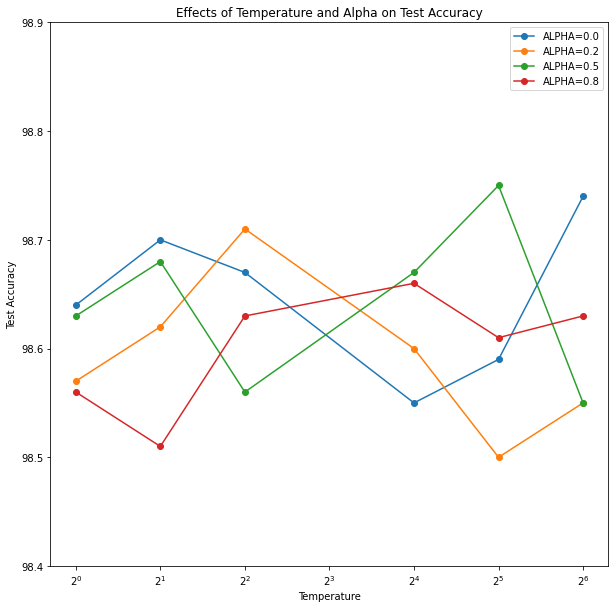

<Figure size 432x288 with 0 Axes>

In [ ]:
#sub_Accuracy_student_0_, sub_Accuracy_student_02_, sub_Accuracy_student_05_, sub_Accuracy_student_08_ = sub_All_Accuracy_student[0: 6],sub_All_Accuracy_student[6: 12],sub_All_Accuracy_student[12: 18],sub_All_Accuracy_student[18: 24] 

fig, ax = plt.subplots(figsize=(10,10))
ax.set_xscale('log',basex=2)
ax.plot(DISTILLATION_TEMPERATURE_spectrum,sub_Accuracy_student_0_, marker='o', label='ALPHA=0.0')
ax.plot(DISTILLATION_TEMPERATURE_spectrum, sub_Accuracy_student_02_, marker='o', label='ALPHA=0.2')
ax.plot(DISTILLATION_TEMPERATURE_spectrum, sub_Accuracy_student_05_, marker='o', label='ALPHA=0.5')
ax.plot(DISTILLATION_TEMPERATURE_spectrum, sub_Accuracy_student_08_, marker='o', label='ALPHA=0.8')
plt.ylim(98.4,98.9)
plt.ylabel('Test Accuracy')
plt.xlabel('Temperature')
plt.title('Effects of Temperature and Alpha on Test Accuracy')
plt.legend()
plt.show()
plt.savefig('sub_talphatestaccuracy.png')

In [ ]:
# compare 2 kd

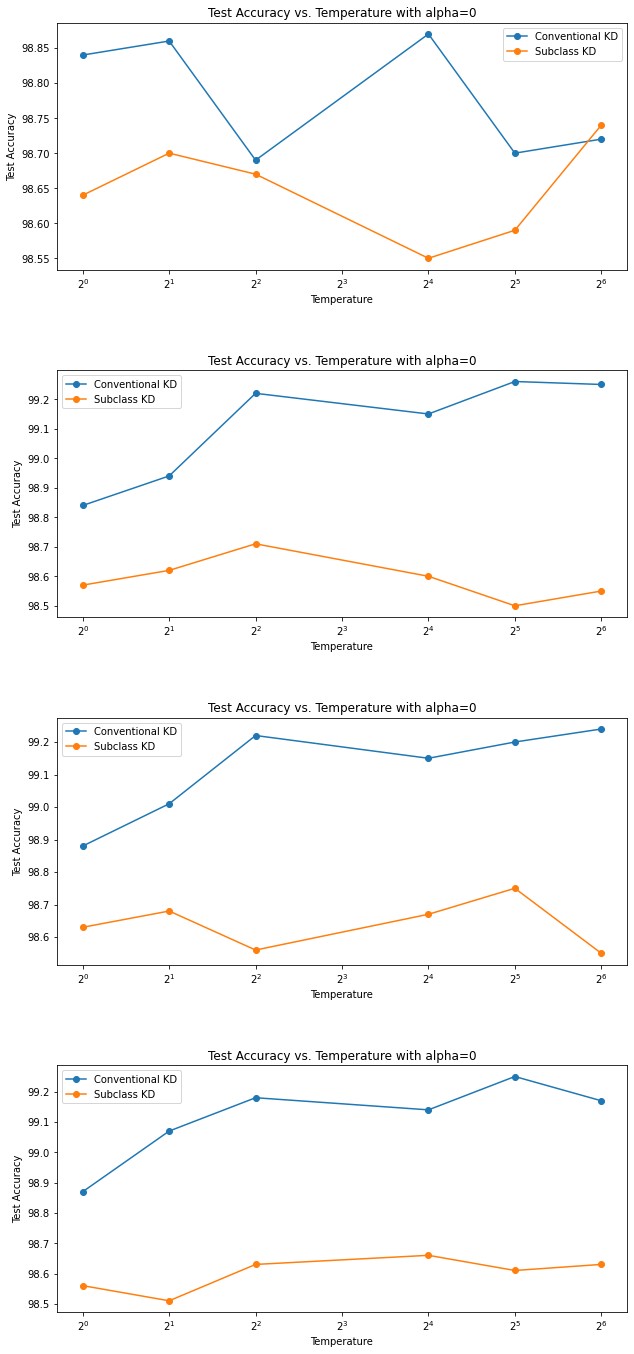

<Figure size 432x288 with 0 Axes>

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(10,20))
for ax in axs.flat:
  ax.set(xlabel='Temperature', ylabel='Test Accuracy')
axs[0].set_xscale('log', basex=2)
axs[1].set_xscale('log', basex=2)
axs[2].set_xscale('log', basex=2)
axs[3].set_xscale('log', basex=2)

axs[0].plot(DISTILLATION_TEMPERATURE_spectrum, Accuracy_student_0_, marker='o', label='Conventional KD')
axs[0].plot(DISTILLATION_TEMPERATURE_spectrum, sub_Accuracy_student_0_, marker='o', label='Subclass KD')
axs[0].set_title('Test Accuracy vs. Temperature with alpha=0')
axs[0].legend()

axs[1].plot(DISTILLATION_TEMPERATURE_spectrum, Accuracy_student_02_, marker='o', label='Conventional KD')
axs[1].plot(DISTILLATION_TEMPERATURE_spectrum, sub_Accuracy_student_02_, marker='o', label='Subclass KD')
axs[1].set_title('Test Accuracy vs. Temperature with alpha=0')
axs[1].legend()


axs[2].plot(DISTILLATION_TEMPERATURE_spectrum, Accuracy_student_05_, marker='o', label='Conventional KD')
axs[2].plot(DISTILLATION_TEMPERATURE_spectrum, sub_Accuracy_student_05_, marker='o', label='Subclass KD')
axs[2].set_title('Test Accuracy vs. Temperature with alpha=0')
axs[2].legend()


axs[3].plot(DISTILLATION_TEMPERATURE_spectrum, Accuracy_student_08_, marker='o', label='Conventional KD')
axs[3].plot(DISTILLATION_TEMPERATURE_spectrum, sub_Accuracy_student_08_, marker='o', label='Subclass KD')
axs[3].set_title('Test Accuracy vs. Temperature with alpha=0')
axs[3].legend()

plt.tight_layout(pad=5.0)
plt.show()
plt.savefig('sub_vs_conv.png')